In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData

plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=22)

In [2]:
def get_peak_to_peak(folder):
    files = os.listdir(folder)
    mi = -1
    ma = -1
    for f in files[:]:
        data = np.loadtxt(folder+'/'+f, skiprows=3)
        f_max = np.max(data[:,1])
        f_min = np.min(data[:,1])
        if mi == -1 or f_min < mi:
            mi = f_min
        if ma != -1 or f_max > ma:
            ma = f_max
    return ma-mi
def get_data(folder):
    data_dir = folder
    sub_folders = os.listdir(data_dir)
    sort_buffer = [int(s) for s in sub_folders if s[0]!='#']
    sort_buffer.sort(key=float)
    sub_folders = sort_buffer
    ampls = []
    for s in sub_folders:
        ampls.append(get_peak_to_peak(data_dir+'/'+str(s)))
    return np.array(sub_folders[:]), ampls[:]/np.max(ampls)


In [3]:
# day1_w_pol = get_data("Day 1/Polarization w pol 0 deg")
day1_wo_pol = get_data("Day 1/Polarization wo pol")
day3 = get_data("Day 3/Wheel")

In [13]:
def func(params, x):
    a, b, c = params
    return a*np.abs(np.cos(b*x+c))

In [123]:
model = Model(func)
data1 = Data(day1_wo_pol[0]/180*np.pi, day1_wo_pol[1], wd=1/(np.ones(np.shape(day1_wo_pol[1]))*0.5/180*np.pi)**2, we=1/(np.ones(np.shape(day1_wo_pol[1]))*5e-2)**2)
data2 = Data(day3[0]/180*np.pi, day3[1], wd=1/(np.ones(np.shape(day3[1]))*0.5/180*np.pi)**2, we=1/(np.ones(np.shape(day3[1]))*5e-2)**2)

odr = ODR(data1, model, beta0=[1, 2, 0.25])
output1=odr.run()
output1.pprint()
odr = ODR(data2, model, beta0=[1, 2, 0.25])
output2=odr.run()
output2.pprint()

Beta: [ 1.00126924  2.08126295 -0.31102902]
Beta Std Error: [0.00947538 0.04192498 0.03393391]
Beta Covariance: [[ 0.00049539 -0.00076467  0.00073799]
 [-0.00076467  0.00969837 -0.00766829]
 [ 0.00073799 -0.00766829  0.00635362]]
Residual Variance: 0.181237014174574
Inverse Condition #: 0.0966807933581466
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.96229061  2.01154176 -0.72693053]
Beta Std Error: [0.00739513 0.02107519 0.0233991 ]
Beta Covariance: [[ 2.23108333e-04 -1.25077331e-04  9.49034185e-05]
 [-1.25077331e-04  1.81203844e-03 -1.87070722e-03]
 [ 9.49034185e-05 -1.87070722e-03  2.23368887e-03]]
Residual Variance: 0.2451181642110619
Inverse Condition #: 0.17506600999701868
Reason(s) for Halting:
  Sum of squares convergence


In [124]:
b1 = output1.beta[1]
b2 = output2.beta[1]
w1 = 1/(output1.cov_beta[1][1])
w2 = 1/(output2.cov_beta[1][1])
# w1 = 1/(output1.sd_beta[1])**2
# w2 = 1/(output2.sd_beta[1])**2
print((w1*b2+w2*b2)/(w1+w2), (w1+w2)**-0.5)

2.011541763981756 0.039073986593320266


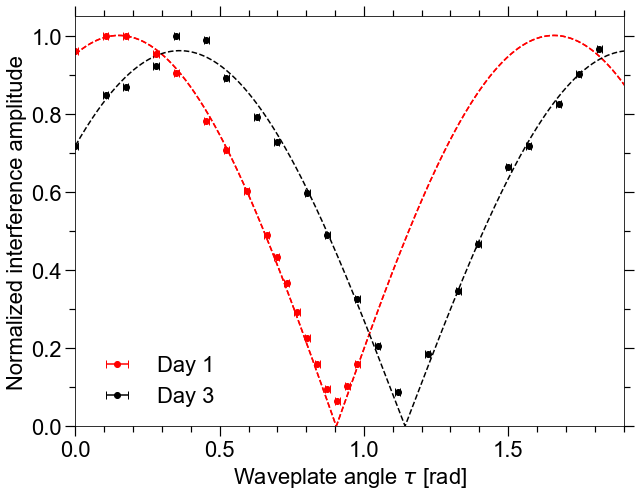

In [122]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 7)

ax.errorbar(day1_wo_pol[0]/180*np.pi, day1_wo_pol[1], fmt='ro', xerr=np.ones(np.shape(day1_wo_pol[1]))*0.5/180*np.pi, label='Day 1', capsize=4)
ax.errorbar(day3[0]/180*np.pi, day3[1], fmt='ko', xerr=np.ones(np.shape(day3[1]))*0.5/180*np.pi, label='Day 3', capsize=4)

xs = np.linspace(0, 2*np.pi/3, 1000)
ax.plot(xs, func(output1.beta, xs), 'r--')
ax.plot(xs, func(output1.beta, xs), 'r--')
ax.plot(xs, func(output2.beta, xs), 'k--')

ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.9)
ax.set_xlabel("Waveplate angle $\\tau$ [rad]")
ax.set_ylabel("Normalized interference amplitude")
ax.legend(frameon=False)
plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.tight_layout()
# plt.savefig('polarization_v3.pdf')

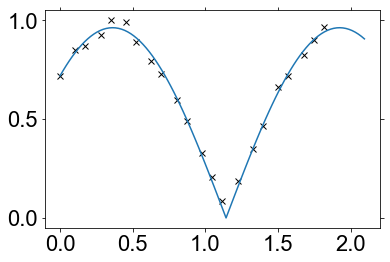

In [43]:
plt.plot(day3[0]/180*np.pi, day3[1], 'kx')
# plt.plot(day1_wo_pol[0]/180*np.pi, day1_wo_pol[1], 'rx')
xs = np.linspace(0, 2*np.pi/3, 100)
plt.plot(xs, func(output2.beta, xs))
# plt.plot(xs, np.abs(np.cos(2*xs-0.25)))

In [19]:
def func(loss, x):
    return (1-loss)*10**(-x)

total_data = np.concatenate((day2,day3), axis=1)

od_theo = Model(func)
data = RealData(total_data[0], total_data[1], sx=np.ones(np.shape(total_data[1]))*0.06)
odr = ODR(data, od_theo, beta0=[0.55])
output=odr.run()
output.pprint()

Beta: [0.57199087]
Beta Std Error: [0.01131007]
Beta Covariance: [[0.22214804]]
Residual Variance: 0.0005758219996238482
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


Beta: [0.51451865 7.00644542 1.46165174]
Beta Std Error: [2.33641228e-02 4.33059332e+06 4.64050653e+05]
Beta Covariance: [[ 1.29660483e+00 -1.20919161e+08  1.29572548e+07]
 [-1.20919161e+08  4.45454632e+16 -4.77333006e+15]
 [ 1.29572548e+07 -4.77333006e+15  5.11492714e+14]]
Residual Variance: 0.0004210089467102809
Inverse Condition #: 2.2182950366215394e-08
Reason(s) for Halting:
  Sum of squares convergence
ipykernel_launcher:3: RuntimeWarning: invalid value encountered in power


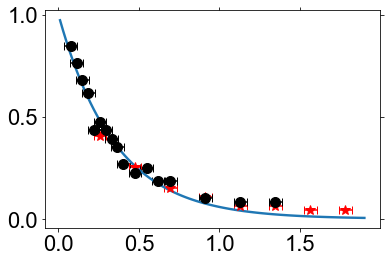

In [8]:
def func(args, x):
    loss, A, B = args
    return (1-loss)*A**(-B*x)

total_data = np.concatenate((day2,day3), axis=1)

od_theo = Model(func)
data = RealData(total_data[0], total_data[1], sx=np.ones(np.shape(total_data[1]))*0.06)
odr = ODR(data, od_theo, beta0=[0.55, 10, 1])
output=odr.run()
output.pprint()

loss, A, B = output.beta

plt.errorbar(day2[0], day2[1]/(1-loss), xerr=np.ones(np.shape(day2[1]))*0.04, fmt='r*', ms=10, label="Day 2", capsize=4)
plt.errorbar(day3[0], day3[1]/(1-loss), xerr=np.ones(np.shape(day3[1]))*0.04, fmt='ko', ms=10, label="Day 3", capsize=4)
ODs = np.linspace(0.01, 1.9, 100)
plt.plot(ODs, A**(-B*ODs), lw=2.4, label="$10^{-OD}$")

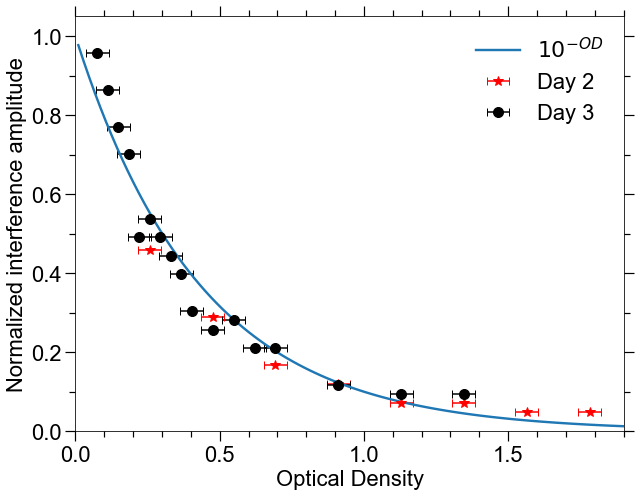

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 7)
loss = 0.572
# ax.plot(day2[0], day2[1]/(1-loss), 'r*', ms=10, label="Day 2")
# ax.plot(day3[0], day3[1]/(1-loss), 'ko', ms=10, label="Day 3")
ax.errorbar(day2[0], day2[1]/(1-loss), xerr=np.ones(np.shape(day2[1]))*0.04, fmt='r*', ms=10, label="Day 2", capsize=4)
ax.errorbar(day3[0], day3[1]/(1-loss), xerr=np.ones(np.shape(day3[1]))*0.04, fmt='ko', ms=10, label="Day 3", capsize=4)
ODs = np.linspace(0.01, 1.9, 100)
ax.plot(ODs, 10**(-ODs), lw=2.4, label="$10^{-OD}$")

ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.9)
ax.set_xlabel("Optical Density")
ax.set_ylabel("Normalized interference amplitude")
ax.legend(frameon=False)
plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.tight_layout()
# fig.savefig("OD_v2.pdf")

Text(0, 0.5, 'Interference amplitude')

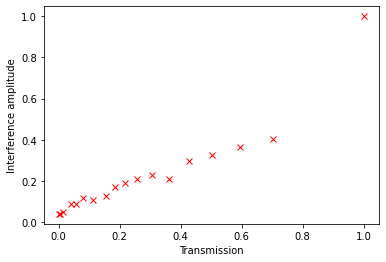

In [24]:
transmissions = [1] + [angle_to_trans(int(a)) for a in sub_folders[1:]]

plt.plot(transmissions, ampls/ampls[0], 'rx')
# plt.yscale("log")
plt.xlabel("Transmission")
plt.ylabel("Interference amplitude")

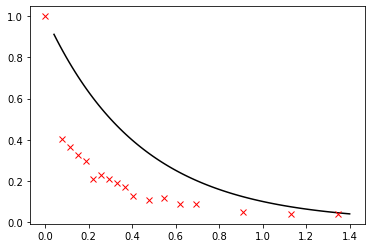

In [18]:
ODs = np.linspace(0.04, 1.4, 100)
data_ODs = [0] + [angle_to_OD(int(a)) for a in sub_folders[1:]]
plt.plot(ODs, 10**(-ODs), 'k')
plt.plot(data_ODs, (ampls/ampls[0]), 'rx')
